# Compare Price and Speed

This notebook runs 200 epochs on a number of CPU and GPU instance types.  This information will then be used to select the best instance type for the [hyper-parameter tunning](tuning.ipynb).

#### Import necessary modules

In [33]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import boto3
import numpy as np
import pandas as pd
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
import seaborn as sns; sns.set()
from time import sleep

## Get the necessary account information

In [13]:
role = get_execution_role()
account = boto3.client('sts').get_caller_identity()['Account']
region = boto3.Session().region_name
image_names = {}
for t in ['cpu', 'gpu']:
    image_names[t] = '{}.dkr.ecr.{}.amazonaws.com/sagemaker-tennis-{}:latest'.format(account, region, t)
    print(image_names[t])

031118886020.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tennis-cpu:latest
031118886020.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tennis-gpu:latest


#### Set for local parameters
Note prices are in $/hour and are from [here](https://aws.amazon.com/sagemaker/pricing/).

In [25]:
n_epochs = 200
n_instances = 1

c = {'ml.m5.large': 0.134, 
     'ml.m5.xlarge': 0.269, 
     'ml.m5.2xlarge': 0.538,
     'ml.m4.xlarge': 0.28, 
     'ml.m4.x2large': 0.56,
     'ml.c5.xlarge': 0.238, 
     'ml.c5.2xlarge': 0.476,
     'ml.c5n.xlarge': 0.302, 
     'ml.c5n.2xlarge': 0.605,
     'ml.c4.xlarge': 0.279, 
     'ml.c4.2xlarge': 0.557}
c = pd.DataFrame(index=c.keys(), columns=['price'], data=c.values())
c['type'] = 'cpu'

g = {'ml.p2.xlarge': 1.26, 
     'ml.p3.2xlarge': 4.284, 
     'ml.g4dn.xlarge': 0.736, 
     'ml.g4dn.2xlarge': 1.053}
g = pd.DataFrame(index=g.keys(), columns=['price'], data=g.values())
g['type'] = 'gpu'

results = pd.concat([c, g])
results['job_name'] = ''
results['time'] = np.nan
del c, g
results

,price,type,job_name,time
ml.m5.large,0.134,cpu,,NaN
ml.m5.xlarge,0.269,cpu,,NaN
ml.m5.2xlarge,0.538,cpu,,NaN
ml.m4.xlarge,0.280,cpu,,NaN
ml.m4.x2large,0.560,cpu,,NaN
ml.c5.xlarge,0.238,cpu,,NaN
ml.c5.2xlarge,0.476,cpu,,NaN
ml.c5n.xlarge,0.302,cpu,,NaN
ml.c5n.2xlarge,0.605,cpu,,NaN
ml.c4.xlarge,0.279,cpu,,NaN


### Please verify that the prices above haven't changed!!!
You may also want to add newly added instances.

## Run Sensitivity

#### Submit all the jobs

In [28]:
#for i in results.index.tolist():
for i in ['ml.m5.large']:
    estimator = Estimator(role=role,
                      train_instance_count=n_instances,
                      train_instance_type=i,
                      image_name=image_names[results.loc[i, 'type']],
                      hyperparameters={'epochs': n_epochs})
    estimator.fit(wait=False)
    results.loc[i, 'job_name'] = estimator._current_job_name

#### Wait for the jobs to complete and compile billable times
Note times are in seconds but prices in $/hour.

In [29]:
client = boto3.client('sagemaker')
#for i in results.index.tolist():
for i in ['ml.m5.large']:
    while True:
        info = client.describe_training_job(TrainingJobName=results.loc[i, 'job_name'])
        if info['TrainingJobStatus'] == 'Completed':
            results.loc[i, 'time'] = info['BillableTimeInSeconds']
            break
        elif info['TrainingJobStatus'] == 'Failed':
            print('ERROR:  {} failed!!!'.format(results.loc[i, 'job_name']))
            break
        else:
            sleep(60)    

#### Compile the job info
Note the cost is in cents.

In [31]:
results['cost'] = results['price'] * results['time'] / 36
results

,price,type,job_name,time,cost
ml.m5.large,0.134,cpu,sagemaker-tennis-cpu-2020-06-26-20-41-23-700,146.0,0.543444
ml.m5.xlarge,0.269,cpu,,NaN,NaN
ml.m5.2xlarge,0.538,cpu,,NaN,NaN
ml.m4.xlarge,0.280,cpu,,NaN,NaN
ml.m4.x2large,0.560,cpu,,NaN,NaN
ml.c5.xlarge,0.238,cpu,,NaN,NaN
ml.c5.2xlarge,0.476,cpu,,NaN,NaN
ml.c5n.xlarge,0.302,cpu,,NaN,NaN
ml.c5n.2xlarge,0.605,cpu,,NaN,NaN
ml.c4.xlarge,0.279,cpu,,NaN,NaN


#### Make a pretty plot 

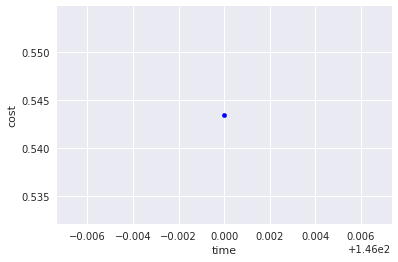

In [35]:
ax = results.plot.scatter(x='time', y='cost', c='blue')


In [32]:
import sagemaker

# Get the bucket name
sagemaker_session = sagemaker.session.Session()
bucket = sagemaker_session.default_bucket()
print(bucket)

sagemaker-us-east-1-031118886020


In [34]:
estimator._current_job_name

'sagemaker-tennis-2020-06-22-03-30-01-701'

In [37]:
# Copy the result archive
import shutil
s3 = boto3.resource('s3')
key = '{}/output/output.tar.gz'.format(estimator._current_job_name)
print(key)
s3.Bucket(bucket).download_file(key, 'output.tar.gz')
shutil.unpack_archive('output.tar.gz')

sagemaker-tennis-2020-06-22-03-30-01-701/output/output.tar.gz


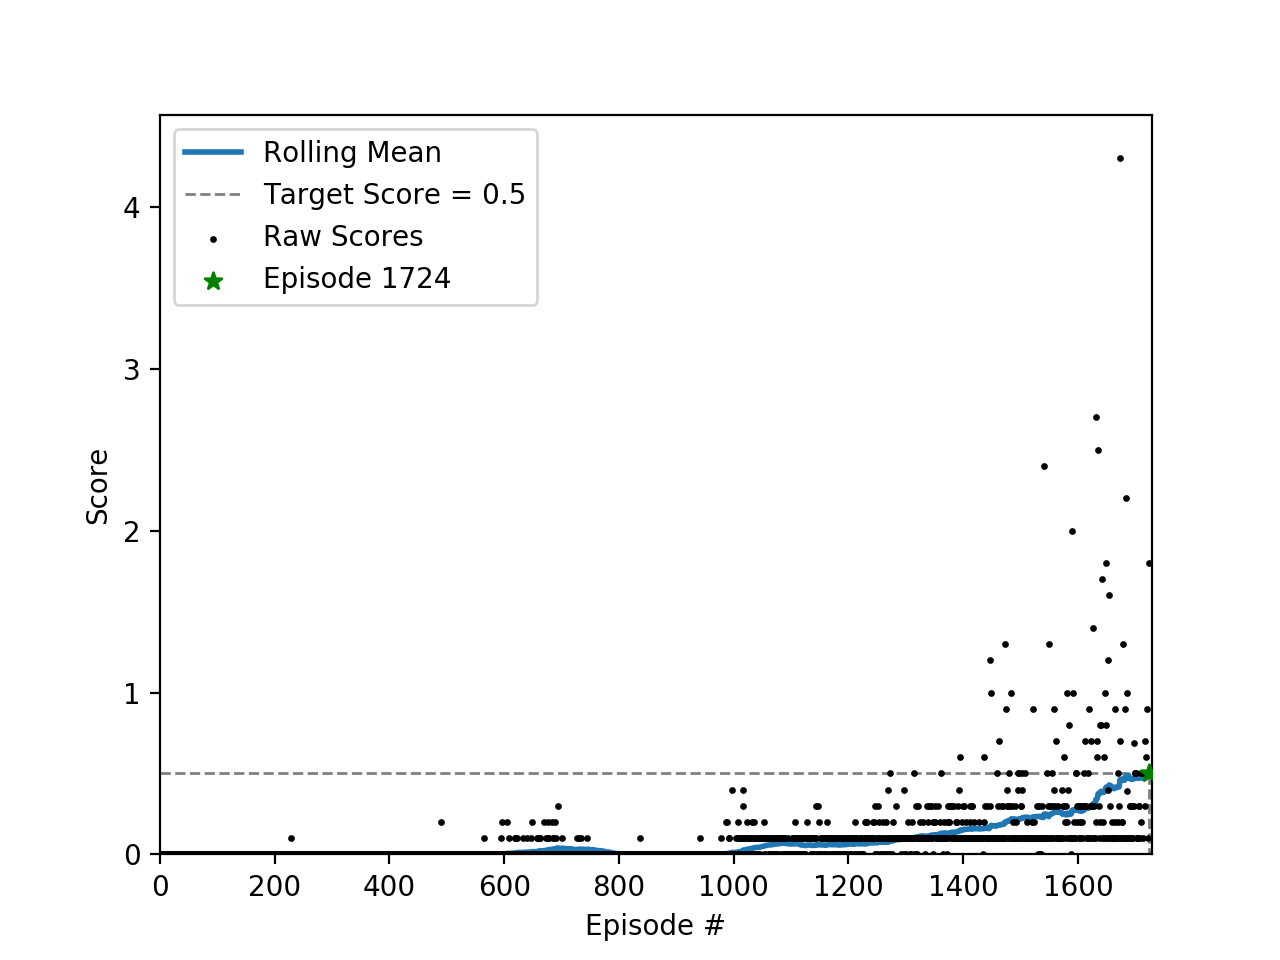

In [38]:
from IPython.display import Image
Image(filename='scores.png') 

# Reference
- [SageMaker Instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/)
- [SageMaker Instance prices](https://aws.amazon.com/sagemaker/pricing/)
- [SageMaker Estimator SDK](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)